In [1]:
# get cm4 so and thetao data ('gn' without regriding)
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
col = open_catalog(url).climate.cmip6_gcs()

dslist = col.search(variable_id = ['so', 'thetao'], table_id = 'Omon', experiment_id = 'piControl', 
           source_id = 'GFDL-CM4', grid_label = 'gn')
ds = dslist['CMIP.NOAA-GFDL.GFDL-CM4.piControl.Omon.gn'].to_dask()
ds = ds.squeeze('member_id').reset_coords('member_id', drop = True)

In [2]:
import gsw

In [4]:
col.search(variable_id = ['siconc'], 
           # table_id = 'Omon', 
           experiment_id = 'piControl', 
           source_id = 'GFDL-CM4', 
           grid_label = 'gn').df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...,NaN,20180701


In [10]:
from dask_gateway import Gateway
gateway = Gateway()
# cluster = GatewayCluster()
options = gateway.cluster_options()

options.worker_cores = 4 # 16 #16 / 4
options.worker_memory = 16 # 32 #32 / 8  

cluster = gateway.new_cluster(options)

cluster.adapt(minimum = 2, maximum = 150)

client = cluster.get_client() 
cluster

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [18]:
client.close()
cluster.close()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1013: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


In [2]:
import numpy as np
import xesmf as xe
import xarray as xr

import copy

In [3]:
# functions for calculating potential density (dens0)

def smow(t):
    a = (999.842594, 6.793952e-2, -9.095290e-3, 1.001685e-4, -1.120083e-6,
         6.536332e-9)
    T68 = t * 1.00024
    return (a[0] + (a[1] + (a[2] + (a[3] + (a[4] + a[5] * T68) * T68) * T68) *
            T68) * T68)

def dens0(s, t):
    T68 = t * 1.00024
    b = (8.24493e-1, -4.0899e-3, 7.6438e-5, -8.2467e-7, 5.3875e-9)
    c = (-5.72466e-3, 1.0227e-4, -1.6546e-6)
    d = 4.8314e-4
    return (smow(t) + (b[0] + (b[1] + (b[2] + (b[3] + b[4] * T68) * T68) *
            T68) * T68) * s + (c[0] + (c[1] + c[2] * T68) * T68) * s *
            s ** 0.5 + d * s ** 2)

In [4]:
def func_sep_dens0(dst, dss):
    da_t = list(dst.groupby("time.month"))[8][-1]
    da_s = list(dss.groupby("time.month"))[8][-1]
    da_dens = dens0(da_s, da_t)
    return da_dens

In [5]:
# functions for calculate MLD
def func_mld(dens_diff, depths):
    '''
    Function for calculate mld from density difference (den - den10 - 0.03) and depth
    Return mixed layer depth 
    '''
    if np.isnan(dens_diff[0]):
        mld = np.nan
    elif dens_diff[0] >= 0:
        mld = np.nan
    else:
        nthr_index = np.where(dens_diff > 0)[0]
        if len(nthr_index) == 0:
            naninds = np.where(np.isnan(dens_diff))[0]
            if len(naninds) > 0:
                nanindex = naninds[0]
            else:
                nanindex = len(depths)
            mld = depths[nanindex-1]
        else:
            nind = nthr_index[0] + 1
            mld = np.interp(0, dens_diff[nind-2:nind], depths[nind-2:nind])                
    return mld

def xr_func_mld(dens):
    '''
    Function for parallel computing
    '''
    dens10 = dens.interp(lev = 10, method = 'linear')  # density at 10m
    dens_diff = dens - dens10 - 0.03               # density differences 
    mld = xr.apply_ufunc(
        func_mld, 
        dens_diff,#.chunk({"time":25, "x":30, "y":30}),  
        dens_diff.lev, 
        input_core_dims = [["lev"], ["lev"]], 
        vectorize = True,
        dask = "parallelized",
        output_dtypes = [dens_diff.lev.dtype],
    )
    return mld

In [6]:
def func_conv_old(dst, dss, d):
    mld = xr_func_mld(func_sep_dens0(dst, dss)) # calculate september potential density and mld
    conv = xr.where(mld >= 2000, mld, np.nan) # select the area where mld > 2000

    conv_area = conv.mean(dim = 'time', skipna = True)
    conv_t = dst.where(conv_area >= 0)
    convt = conv_t.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
    
    ind_t = convt.sel(lev = d, method = 'nearest')
    conv_ind = (ind_t - ind_t.mean('year'))/ind_t.std('year') * -1
    
    return conv_area, conv_ind

In [8]:
def func_conv(dst, dss):
    mld = xr_func_mld(func_sep_dens0(dst, dss)) # calculate september potential density and mld
    conv = xr.where(mld >= 2000, mld, np.nan) # select the area where mld > 2000
    conv_year = conv.mean(dim = 'x', skipna = True).mean(dim = 'y', skipna = True)
    convyear_mld = xr.where(conv_year >= 0, mld, np.nan)
    conv_mld = convyear_mld.mean(dim = 'time', skipna = True)
    conv_area = xr.where(conv_mld >= 2000, conv_mld, np.nan)
    return conv_year, conv_mld, conv_area

In [9]:
def func_conv2(dst, dss):
    mld = xr_func_mld(func_sep_dens0(dst, dss)) # calculate september potential density and mld
    mldstd = mld.std(dim = 'time')
    mld_mean = mld.mean(dim = 'time')
    newstd = mldstd/mld_mean
    return mldstd, newstd

In [10]:
def func_convt_all(dst, dss, d):
    mldstd = func_conv2(dst, dss)
    dst_ann = dst.groupby('time.year').mean('time')
    convareat = xr.where(mldstd >= d, dst_ann, np.nan)
    convt = convareat.mean(dim = 'x', skipna = True).mean(dim = 'y', skipna = True)
    return convt    

In [11]:
# calculate the z-score (spatial) 
def func_conv_stdz(dst, dss):
    mld = xr_func_mld(func_sep_dens0(dst, dss)) 
    mldstd = mld.std(dim = 'time')
    

In [12]:
ds_weddell = ds.sel(x = slice(-60, 30), y = slice(-90, -60))  
ds_ross = ds.sel(x = slice(-210, -135), y = slice(-90, -60)) 

In [7]:
def func_new_conv(dst, dss, l=2000):
    mldsep = xr_func_mld(func_sep_dens0(dst, dss))
    mldsepstd = mldsep.std(dim = 'time')
    mldsepstdzs = (mldsepstd - mldsepstd.mean())/mldsepstd.std()
    # dst_ann = dst.groupby('time.year').mean('time')
    # convareat = xr.where(mldsepstdzs >= 2, dst_ann, np.nan)
    # convt = convareat.mean(dim = 'x', skipna = True).mean(dim = 'y', skipna = True)
    # tlev = convt.sel(lev = l, method = 'nearest')
    # convinx = (tlev - tlev.mean('year'))/tlev.std('year')
    return mldsepstdzs#, convt

In [8]:
ds_so = ds.sel(y = slice(-90, -40)) 

In [9]:
zs_so = func_new_conv(ds_so.thetao, ds_so.so)

In [46]:
zs_weddell, convinx_weddell = func_new_conv(ds_weddell.thetao, ds_weddell.so, 2000)
zs_ross, convinx_ross = func_new_conv(ds_ross.thetao, ds_ross.so, 2000)

In [11]:
zs_so = zs_so.load()

In [12]:
zs_weddell = zs_so.sel(x = slice(-60, 30), y = slice(-90, -60))  
zs_ross = zs_so.sel(x = slice(-210, -135), y = slice(-90, -60)) 

In [13]:
dst_ann_so = ds_so.thetao.groupby('time.year').mean('time')

convt_weddell = dst_ann_so.where(zs_weddell > 2).mean(dim = 'x', skipna = True).mean(dim = 'y', skipna = True)
convt_ross = dst_ann_so.where(zs_ross > 2).mean(dim = 'x', skipna = True).mean(dim = 'y', skipna = True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(sl

In [15]:
convt_ross.load()

<xarray.DataArray 'thetao' (year: 500, lev: 35)>
array([[-1.1990832, -1.2102057, -1.2448897, ...,        nan,        nan,
               nan],
       [-1.1684542, -1.1868435, -1.2470313, ...,        nan,        nan,
               nan],
       [-1.0864623, -1.1079489, -1.1614237, ...,        nan,        nan,
               nan],
       ...,
       [-1.1418555, -1.1712193, -1.2456765, ...,        nan,        nan,
               nan],
       [-1.0999595, -1.1313229, -1.2004085, ...,        nan,        nan,
               nan],
       [-1.1083082, -1.1319593, -1.1892289, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * year     (year) int64 151 152 153 154 155 156 ... 645 646 647 648 649 650

In [16]:
convinx_weddell = (convt_weddell.sel(lev = 2000, method = 'nearest') - convt_weddell.sel(lev = 2000, method = 'nearest').mean('year'))/convt_weddell.sel(lev = 2000, method = 'nearest').std('year')
convinx_ross = (convt_ross.sel(lev = 2000, method = 'nearest') - convt_ross.sel(lev = 2000, method = 'nearest').mean('year'))/convt_ross.sel(lev = 2000, method = 'nearest').std('year')

In [17]:
zs_so.to_netcdf('mldzscore_cm4.nc')
convt_weddell.to_netcdf('temp_weddellconv_cm4.nc')
convt_ross.to_netcdf('temp_rossconv_cm4.nc')
convinx_weddell.to_netcdf('convinx_weddell_cm4.nc')
convinx_ross.to_netcdf('convinx_ross_cm4.nc')

In [36]:
convinx_weddell = (convt_weddell.sel(lev = 2500, method = 'nearest') - convt_weddell.sel(lev = 2500, method = 'nearest').mean('year'))/convt_weddell.sel(lev = 2500, method = 'nearest').std('year')
convinx_ross = (convt_ross.sel(lev = 2500, method = 'nearest') - convt_ross.sel(lev = 2500, method = 'nearest').mean('year'))/convt_ross.sel(lev = 2500, method = 'nearest').std('year')

In [45]:
conv_t_200m_weddell = func_convt_all(ds_weddell.thetao, ds_weddell.so, 200)

conv_t_200m_ross = func_convt_all(ds_ross.thetao, ds_ross.so, 200)

In [95]:
conv_t_500m_ross = func_convt_all(ds_ross.thetao, ds_ross.so, 500)

In [12]:
conv_area_weddell_old, convt_500_weddell_old = func_conv_old(ds_weddell.thetao, ds_weddell.so, 500)

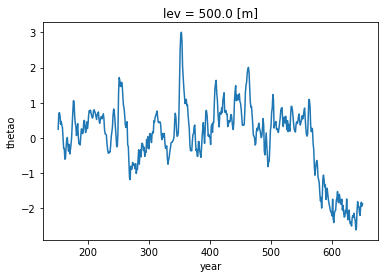

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.9/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1129)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/iostream.py", line 

In [22]:
convt_500_weddell_old.plot()

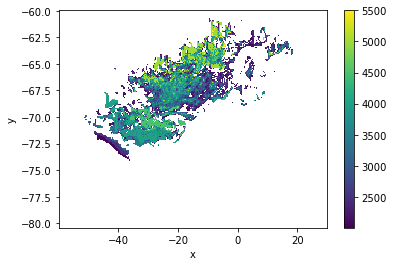

In [14]:
conv_area_weddell_old.plot()

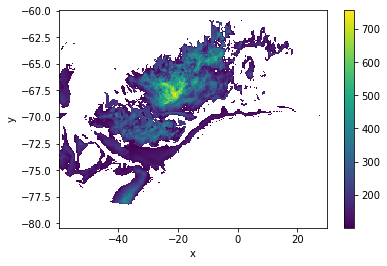

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
distributed.client - ERROR - Exception raised while shutting down cluster prod.c56f0aafe0f44df490d8ffbe9555d18d
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py", line 992, in _stop_internal
    await self.gateway._stop_cluster(self.name)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py", line 653, in _stop_cluster
    await self._request("DELETE", url)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py", line 396, in _request
    resp = await session.request(method, url, json=json, **self._request_kwargs)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/aiohttp/client.py", line 535, in _request
    conn = await self._connector.connect(
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/aiohttp/connector.py", line 542, in connect
  

In [99]:
mldstd_weddell.where(mldstd_weddell>100).plot()

In [19]:
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

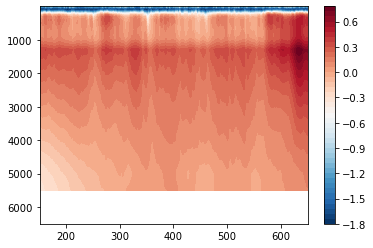

In [29]:
pltdata = convt_weddell
im = plt.contourf(pltdata.year, pltdata.lev, pltdata.transpose(), levels = 50,cmap=plt.cm.RdBu_r) #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im)#, extend='none')

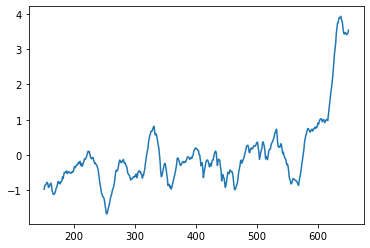

In [38]:
plt.plot(convinx_weddell.year, convinx_weddell)

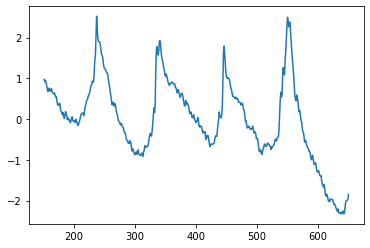

In [98]:
ind_t = conv_t_500m_ross.sel(lev = 2000, method = 'nearest')
conv_ind = (ind_t - ind_t.mean('year'))/ind_t.std('year') * -1
plt.plot(conv_ind.year, conv_ind)

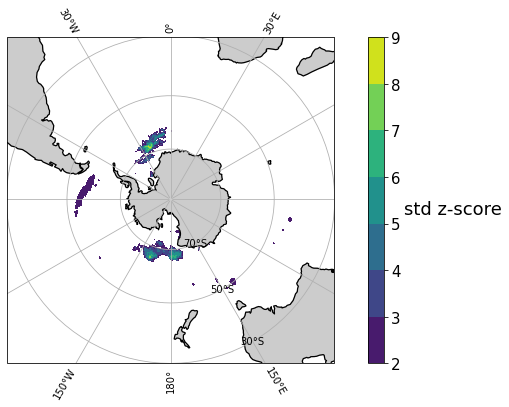

In [23]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=1, color='0.8')
ax.add_feature(cfeature.COASTLINE, linewidth=1.25)

gl = ax.gridlines(
    xlocs = np.arange(-180,180,30), 
    ylocs = np.arange(-90,90,20),
    draw_labels=True, y_inline=True)

# plt_mld, plt_lon = add_cyclic_point(conv_area_ross, coord=conv_area_ross.lon)
# my_level = np.arange(-2,2,5)
ptest = zs_so.where(zs_so > 2)
im = ax.contourf(ptest.lon, ptest.lat, ptest, transform=ccrs.PlateCarree())#, levels = 2)#, cmap=plt.cm.jet)
cbar = plt.colorbar(im)
cbar.set_label('std z-score', fontsize=18, rotation=0, horizontalalignment = 'left')
cbar.ax.tick_params(labelsize=15) 
# plt.title('Average September MLD - year '+ str(start_year) + '-' + str(end_year) + ', ' + model_name, fontsize=18)